# Cirq basics

## Install and Use Cirq

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    %pip install --quiet cirq
    print("installed cirq.")

installing cirq...
     |████████████████████████████████| 47 kB 806 kB/s 
     |████████████████████████████████| 55 kB 564 kB/s 
     |████████████████████████████████| 437 kB 14.8 MB/s 
     |████████████████████████████████| 328 kB 40.1 MB/s 
     |████████████████████████████████| 1.6 MB 52.1 MB/s 
     |████████████████████████████████| 220 kB 55.3 MB/s 
     |████████████████████████████████| 10.1 MB 43.7 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 145 kB 48.7 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 229 kB 44.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 243 kB 44.5 MB/s 
     |████

## Create and Run a Simple Circuit

In [3]:
import cirq

# Create a qubit
qubit = cirq.GridQubit(0, 0)

# Create a circuit which calculates the square root of NOT, then measure
circuit = cirq.Circuit(
  cirq.X(qubit) ** 0.5, cirq.measure(qubit, key='m')  
)
print("Circuit:")
print(circuit)

# Simulate the circuit 10 times
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)
print("Results:")
print(result)


Circuit:
(0, 0): ───X^0.5───M('m')───
Results:
m=0101001001


## Run and Plot

Circuit:
(0, 0): ───X^0.5───M('m')───


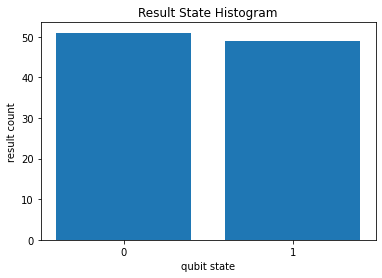

In [4]:
import matplotlib.pyplot as plt

# Create a qubit
qubit = cirq.GridQubit(0, 0)

# Create a circuit which calculates the square root of NOT, then measure
circuit = cirq.Circuit(
  cirq.X(qubit) ** 0.5, cirq.measure(qubit, key='m')  
)
print("Circuit:")
print(circuit)

# Simulate the circuit 100 times
result = cirq.Simulator().run(circuit, repetitions=100)
_ = cirq.vis.plot_state_histogram(result, plt.subplot())


## Use Gates

Circuit:

a: ───H───────────────

b: ───H───@───H───M───
          │
c: ───────X───────────


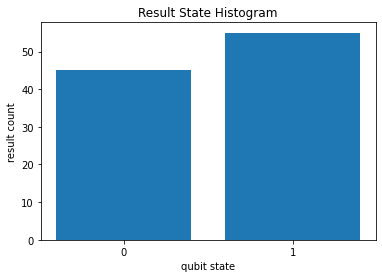

In [5]:
# Define three qubits
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")
m = cirq.NamedQubit("m")

# Define operations
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b,c), cirq.H(b),cirq.measure(b)]

# Create and Print circuit
circuit = cirq.Circuit(ops) 
print("Circuit:\n")
print(circuit) 

# Simulate the circuit 100 times
result = cirq.Simulator().run(circuit, repetitions=100)
_ = cirq.vis.plot_state_histogram(result, plt.subplot())
